In [1]:
from indra_cogex.client import Neo4jClient
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
client = Neo4jClient()

INFO: [2024-05-16 03:09:37] numexpr.utils - NumExpr defaulting to 8 threads.
INFO: [2024-05-16 03:09:38] indra_cogex.client.neo4j_client - Using configured URL for INDRA neo4j connection
INFO: [2024-05-16 03:09:38] indra_cogex.client.neo4j_client - Using configured credentials for INDRA neo4j connection


## **Create a Histogram to Find the Top 30 Journals Researching Cancer**

This method used this query:

"MATCH p1=(gene1)-[:gene_disease_association]->(disease{name:"cancer"})\
MATCH p2=(gene2)-[:gene_disease_association]->(disease{name:"cancer"}\
MATCH p3= (gene1)-[r:indra_rel]->(gene2)\
MATCH p4=(e:Evidence)-[]->(pub:Publication)-[]->(j:Journal)\
WHERE gene1.id <> gene2.id AND e.stmt_hash = r.stmt_hash\
RETURN disease.name, j.title, count(distinct pub)"

I picked the journal with the second highest frequency because the first journal is simply a large publisher, skewing the data. 


In [13]:
def get_df2():

    # cypher query to get the journal, name and publications
    
    # pubmed entries w mesh annotations, rel: annotated_with, find the mesh term for lung cancer and look up the pubmed ids that are 
    # annotated w that term and look for the journals 
    # could calculate the ratio, like number of pubs about this disease/total#pubs to get who is publishing the most -> normalize the count
    
    cypher = """MATCH (n:BioEntity)<-[:annotated_with]-(pub:Publication)-[:published_in]->(j:Journal)
    WHERE n.id = "mesh:D008175"
    WITH j, count (distinct pub) as LungPubs ORDER BY count (distinct pub) desc LIMIT 20
    MATCH (n1:BioEntity)<-[:annotated_with]-(pub1:Publication)-[:published_in]->(j:Journal)
    RETURN j.name, j.id, count(distinct pub1) as AllPubs, LungPubs, LungPubs*100/count(distinct pub1) as Ratio 
    ORDER BY LungPubs*100/count(distinct pub1) DESC """

    results = client.query_tx(cypher)
    # loads the results into a dataframe 
    df = pd.DataFrame(results, columns=["name", "id", "Total Pub", "Lung Pub", "Ratio"])
    
    return df
    
df = get_df2()
df


,name,id,Total Pub,Lung Pub,Ratio
0,Clinical Lung Cancer,nlm:100893225,2138,2012,94
1,Lung Cancer,nlm:8800805,6770,6300,93
2,Journal of Thoracic Oncology,nlm:101274235,5480,4801,87
3,None,nlm:101126433,1995,1707,85
4,Thoracic Cancer,nlm:101531441,2465,1667,67
5,None,nlm:0413533,12377,1788,14
6,None,nlm:7810034,21263,2211,10
7,Journal of Clinical Oncology,nlm:8309333,25917,2446,9
8,International Journal of Radiation Oncology Bi...,nlm:7603616,24193,2258,9
9,None,nlm:8102988,24442,2218,9


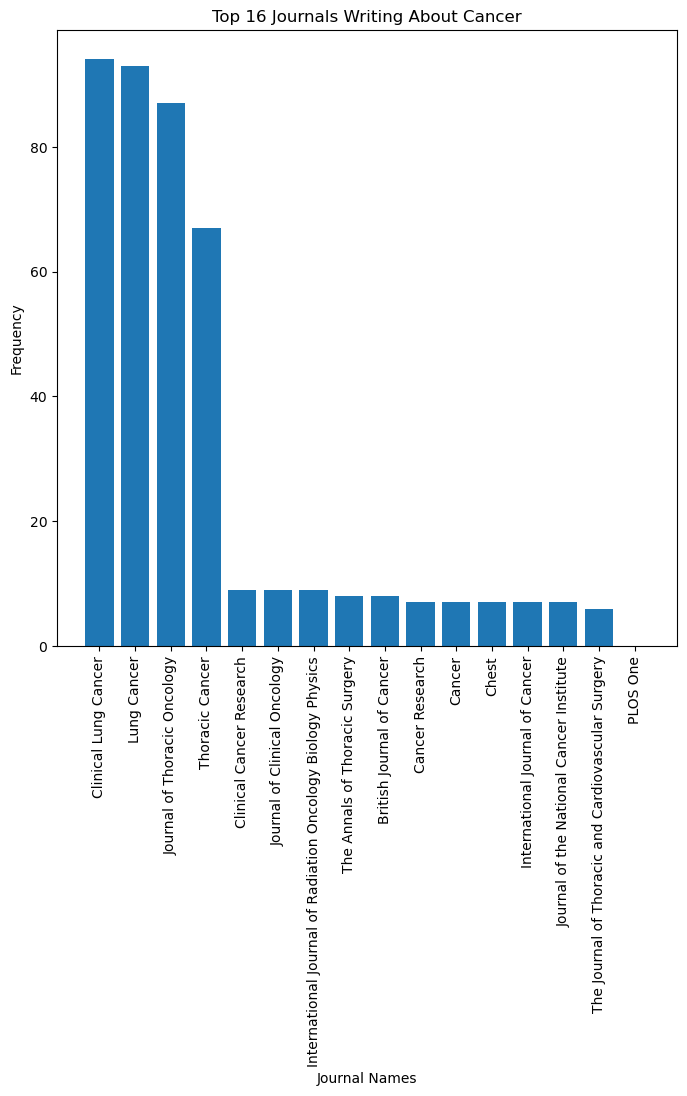

,index,name,id,Total Pub,Lung Pub,Ratio
0,0,Clinical Lung Cancer,nlm:100893225,2138,2012,94
1,1,Lung Cancer,nlm:8800805,6770,6300,93
2,2,Journal of Thoracic Oncology,nlm:101274235,5480,4801,87
3,4,Thoracic Cancer,nlm:101531441,2465,1667,67
4,10,Clinical Cancer Research,nlm:9502500,20160,1877,9
5,7,Journal of Clinical Oncology,nlm:8309333,25917,2446,9
6,8,International Journal of Radiation Oncology Bi...,nlm:7603616,24193,2258,9
7,11,The Annals of Thoracic Surgery,nlm:15030100R,39122,3295,8
8,12,British Journal of Cancer,nlm:0370635,24814,2028,8
9,13,Cancer Research,nlm:2984705R,53264,3828,7


In [19]:
# sorts the dataframe to get the top publications
df = df.sort_values(by = "Ratio", ascending = False)
df = df.dropna(axis = 0)
df = df.reset_index()

# plots a histogram of the top 30 publications 
def plot_histogram2():
    plt.figure(figsize=(8, 8))
    plt.title("Top 16 Journals Writing About Lung Cancer")
    plt.bar(df["name"].values, df["Ratio"].values)
    plt.xlabel("Journal Names")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()
    
plot_histogram2()
df

## **Finding Novel Genes**
**This code finds all of the genes relating to lung cancer in the database, and all the genes in the journal "Lung Cancer: Journal of the International Association for the Study of Lung Cancer", and finds the genes listed in the database that are not mentioned in the journal, the genes mentioned in the journal that are not listed in the database, and the common genes. Based off the genes listed in the database that were not mentioned in the journal, I manually looked up the genes and saw how many PubMed articles linked that specific gene to lung cancer, to identify genes that could be further studied to explore their correlation to lung cancer.**

In [25]:
def get_gene_lists():
    
    # cyphers to get genes from the journal and database relating to lung cancer
    journal_cypher = '''MATCH p3=(gene1:BioEntity)-[r:indra_rel]->(gene2:BioEntity)
    MATCH p4=(e:Evidence)-[:has_citation]->(pub:Publication)-[:published_id]->(j:Journal) 
    WHERE gene1.id <> gene2.id AND e.stmt_hash = r.stmt_hash AND j.id='nlm:8800805' unwind [gene1, gene2] as gene 
    RETURN gene.name, gene.id, count(r)
    ORDER BY count(r) desc'''
    database_cypher = """MATCH p1=(gene1)-[:gene_disease_association]->(subdisease)-[:isa*0..]->(disease)
        WHERE disease.id in ["mesh:D008175",'doid:3905']
        RETURN distinct gene1.name, gene1.id"""
    
    journal_results = client.query_tx(journal_cypher)
    database_results = client.query_tx(database_cypher)

    # loads the results into 2 dataframes
    journal_df = pd.DataFrame(journal_results, columns=["name", "gene_id", "indra statements"])
    database_df = pd.DataFrame(database_results, columns=["name", "gene_id"])

    return journal_df, database_df
    
journal_df, database_df = get_gene_lists()

# for the journal, filters for genes starting with hgnc to match with the database
journal_df = journal_df[journal_df["gene_id"].str.startswith("hgnc")]
novel_df = journal_df[~journal_df["gene_id"].isin(database_df["gene_id"])]



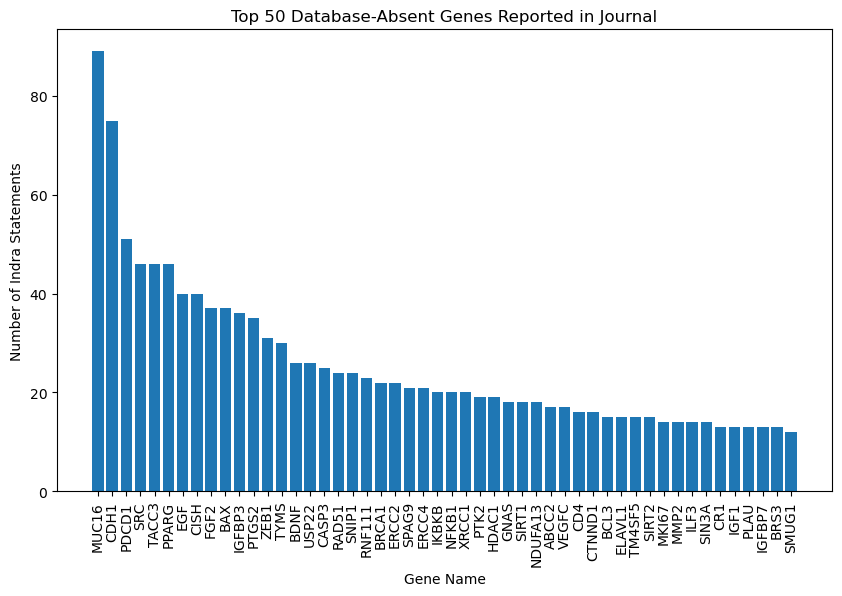

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(novel_df["name"].head(50), novel_df["indra statements"].head(50))
plt.xlabel("Gene Name")
plt.ylabel("Number of Indra Statements")
plt.title("Top 50 Database-Absent Genes Reported in Journal")
plt.xticks(rotation=90)
plt.show()


In [28]:
novel_df.head(10)

,name,gene_id,indra statements
18,MUC16,hgnc:15582,89
22,CDH1,hgnc:1748,75
34,PDCD1,hgnc:8760,51
40,SRC,hgnc:11283,46
41,TACC3,hgnc:11524,46
43,PPARG,hgnc:9236,46
49,EGF,hgnc:3229,40
50,CISH,hgnc:1984,40
58,FGF2,hgnc:3676,37
59,BAX,hgnc:959,37


### Comparing the Gene Lists
Compare the two lists and see overlap between genes that are only showing up in journal vs disease to see if genes in the journal are relevant and vice versa.Determine relevance based on what the paper says, or computational approach:
"what are the pathways that connect the novel genes to the ones that are already associated with disease" 
like if gene y is relevant to disease and gene x activates in then gene x should also be relevant 


In [ ]:
# common genes, and then genes that are present in the journal but not the database 
common_genes = set(journal_df["name"]).intersection(set(database_df["name"]))
print(len(common_genes))

gene_list = [genes for genes in journal_df["name"].values if genes not in database_df["name"].values ]
print(gene_list)

In [1]:
from indra.assemblers.html import HtmlAssembler

In [2]:
gene_name = "MUC16"
stmts = [] # ... get a list of INDRA Statement objects for each of the genes above, 
           # e.g., MUC16 that correspond to the column count above, e.g., 89 for MUC16
    

ha = HtmlAssembler(stmts,
                   title='Statements for %s' % gene_name,
                   db_rest_url='https://db.indra.bio')
ha.save_model('%s_statements.html' % gene_name)